In [1]:
aud1='/Users/zombie/Downloads/datadrive/theWitcher/wavs/audio126.wav'
aud2='/Users/zombie/Downloads/datadrive/theWitcher/revWavs/audio126.wav'
wav='/Users/zombie/Downloads/datadrive/ljspeech/wavs/'
rev='/Users/zombie/Downloads/datadrive/ljspeech/revWavs/'

In [2]:
import librosa, os
import random
from os import listdir
from glob import glob
import numpy as np
from librosa import display
from itertools import cycle, islice, chain
import torch
from os import listdir
import torchvision.transforms as transforms
from matplotlib import cm
import matplotlib.pyplot as plt
from utils import complexToPolar, polarToComplex, reconstructAudioFromBatches
from torch.utils.data import Dataset, IterableDataset, DataLoader
%matplotlib inline

In [3]:
from dataset import TrainDataset
dataConfig= {
"train": {
    "wavPath": "../datadrive/ljspeech/wavs/",
    "revPath": "../datadrive/ljspeech/revWavs/",
    "samplingRate": 16000,
    "shuffle":True,

  "stftParams":{
    "window":"hamming",
    "n_fft":1024,
    "win_length":32

    }
}
}

In [4]:
dset=TrainDataset(**dataConfig['train'])
loader=DataLoader(dset, batch_size=32)
i=0
maxs=[]
maxis=[]
for batch in loader:
    print('yes {}'.format(i), end="\r")
    maxs.append(batch[0].max())
    maxis.append(batch[1].max())
    i+=1
    if i==3:
        break
#     print(batch[0].max())
    

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvLayer(nn.Module):
    """CBL: Conv -> BN -> LeakyReLU
        CL: Conv -> LeakyReLU
        CBR: Conv->BN->ReLU
    """

    def __init__(self, inChannels, outChannels, midChannels=None, kernelSize=5, layerType="CBL"):
        super(ConvLayer, self).__init__()
        if not midChannels:
            midChannels = outChannels
        if layerType == "CBL":
            self.layer = nn.Sequential(
                nn.Conv2d(in_channels=inChannels, out_channels=midChannels, kernel_size=kernelSize, padding=2),
                nn.BatchNorm2d(num_features=midChannels),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )
        elif layerType == "CL":
            self.layer = nn.Sequential(
                nn.Conv2d(in_channels=inChannels, out_channels=midChannels, kernel_size=kernelSize, padding=2),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )
        elif layerType == "CBR":
            self.layer = nn.Sequential(
                nn.Conv2d(in_channels=inChannels, out_channels=midChannels, kernel_size=kernelSize, padding=2),
                nn.BatchNorm2d(num_features=midChannels),
                nn.ReLU(inplace=True)
            )
        else:
            NotImplementedError(self.__class__.__init__)

    def forward(self, input_):
        return self.layer(input_)


class Upsample(nn.Module):
    def __init__(self, inChannels, outChannels, kernelSize=5, bilinear=True, layerType="CBL"):
        super(Upsample, self).__init__()
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample=nn.ConvTranspose2d(in_channels=inChannels, out_channels=inChannels // 2, kernel_size=5,stride=2)
        self.conv = ConvLayer(inChannels, outChannels, layerType=layerType)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)




class Downsample(nn.Module):
    def __init__(self, inChannels, outChannels, maxpool=True, layerType="CBR"):
        super(Downsample, self).__init__()
        self.isMaxpool = maxpool
        self.convLayer = ConvLayer(inChannels, outChannels, layerType=layerType)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, input_):
        return self.maxpool(self.convLayer(input_))



class UNet(nn.Module):
    def __init__(self, nChannels, nClasses, dropout=0.5, activation="tanh"):
        super(UNet, self).__init__()
        self.nChannels = nChannels
        self.nClasses = nClasses

        if activation=="tanh":
            self.DCT = nn.Sequential(
                nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=1),
                nn.Tanh()
            )
        else:
            self.DCT = nn.Sequential(
                nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=1),
                nn.Sigmoid()
            )


        self.dropout = nn.Dropout(dropout)
        self.inc = ConvLayer(nChannels, 16, layerType="CL")
        self.down1 = Downsample(16, 32, layerType="CBL")
        self.down2 = Downsample(32, 64, layerType="CBL")
        self.down3 = Downsample(64, 128, layerType="CBL")
        self.down4 = Downsample(128, 256, layerType="CBL")
        self.down5 = Downsample(256, 512, layerType="CBR")
        # self.middle = Downsample(512, 512, layerType="CBR")
        self.up1 = Upsample(512, 256)
        self.up2 = Upsample(256, 128)
        self.up3 = Upsample(128, 64)
        self.up4 = Upsample(64, 32)
        self.up5 = Upsample(32, 16)
        self.up6 = Upsample(16, nClasses, activation)

    def forward(self, x):
        # 1x256x256
        x1 = self.inc(x) # 16x256x256
        x2 = self.down1(x1) # 32x128x128
        x3 = self.down2(x2) # 64x64x64
        x4 = self.down3(x3) # 128x32x32
        x5 = self.down4(x4) # 256x16x16
        x6 = self.down5(x5) # 512x8x8
        x = self.up1(x6, x5) # 256x16x16
        x=self.dropout(x) 
        x = self.up2(x, x4) # 128x32x32
        x = self.dropout(x)
        x = self.up3(x, x3) # 64x64x64
        x=self.dropout(x) 
        x = self.up4(x, x2) # 32x128x128
        x = self.dropout(x)
        x = self.up5(x, x1) # 16x256x256
        output = self.DCT(x)
        return output

In [54]:
net=UNet(1,1)

In [56]:
net(torch.rand(1,1, 512,512)).shape

torch.Size([1, 1, 512, 512])

In [7]:
batch[0].shape

torch.Size([32, 1, 512, 512])

In [8]:
temp=batch[0][1][0]
temp1=batch[1][1][0]

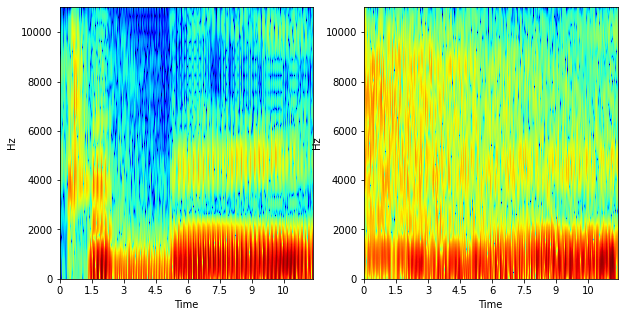

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.power_to_db(temp.numpy()), cmap=cm.jet, y_axis="hz", x_axis="time")
plt.subplot(1,2,2)
librosa.display.specshow(librosa.power_to_db(temp1.numpy()), cmap=cm.jet,y_axis="hz", x_axis="time")

## test dataloader

In [104]:
from glob import glob
from os import listdir
import numpy as np
from itertools import chain, cycle
import librosa, torch, random
from torch.utils.data import Dataset
from utils import polarToComplex, complexToPolar

In [83]:
stftParams={
    "window":'hamming',
    "n_fft":1024,
    "win_length":32,
}
wav="../datadrive/test/"
wavfile="../datadrive/test/LJ050-0090.wav"

In [336]:
class TestDataset(Dataset):
    def __init__(self, wavFile, samplingRate, stftParams):
        audio, _ = librosa.load(wavFile, sr=samplingRate)
        self.stft=librosa.stft(audio, **stftParams)
        self.istftParams={key:val for key, val in stftParams.items() if key!="n_fft"}
    
    def __len__(self):
        return self.stft.shape[0]
    
    def reconstructAudio(self, newMag):
        audio=[]
        for idx, batchM in enumerate(newMag):
            try:
                tempAudio=librosa.istft(polarToComplex(batchM.numpy()[0], self.phase[idx].numpy()[0]), **self.istftParams)
            except:
                tempAudio = librosa.istft(polarToComplex(batchM[0], self.phase[idx][0]), **self.istftParams)
                
            audio.extend(tempAudio)
        
        return audio
    
    
    def transform(self, X):
        """Normalizes the values between 0 and 1"""
        return (X - X.min()) / (X.max() - X.min())

    def squaredChunks(self, array):
        """Accepts numpy array of shape [x, y] returns squared arrays split along y-axis"""
        xdim=array.shape[0]//2*2
        ydim=array.shape[1]
        ydimHead=ydim//xdim*xdim #y-dim of the initial batches
        ydimTail=ydim-ydim//xdim*xdim # y-dim of the last batch 
        batches=np.asarray(np.hsplit(array[:xdim,:ydimHead], ydim//xdim))


        #pad the last batch with minimum value of spectrogram
        tailBatch=array[:xdim, ydimHead:]
        tailB=np.full((xdim, xdim), array.min())
        tailB[:, :ydimTail]=tailBatch
        batches=np.concatenate((batches, np.expand_dims(tailB, axis=0)), axis=0)
        batches=self.transform(batches)
        return np.expand_dims(batches, axis=1)
    
    def audioProcessing(self):
        mag, phase=complexToPolar(self.stft)
        mag=self.squaredChunks(mag)
        self.phase=self.squaredChunks(phase)
        return mag
    
    def __call__(self):
        return self.audioProcessing()

In [363]:
def testIterations(model, path, samplingRate, batchSize, device, stftParams):
    model.to(device)
    model.eval()
    generatedAudios=[]
    filelist=[i for i in os.listdir(path) if not i.startswith('.')]
    for idx, file in enumerate(filelist):
        wavpath=glob(path+file)[0]
        dset=getData(wavpath, samplingRate, stftParams)
        inp=dset()
        datapoints=inp.shape[0]
        for i in range(0, datapoints, batchSize):
            print("Generating Audio {}/{}:  Progress... {}/{}".format(idx+1, len(filelist), i, datapoints))
            if i==0:
                output=model(torch.from_numpy(inp[i:i+batchSize]))
            else:
                output=torch.cat((output, model(torch.from_numpy(inp[i:i+batchSize]))))
        generatedAudios.append(dset.reconstructAudio(output.detach().numpy()))
    return generatedAudios

In [369]:
path="test/"
samplingRate=16000
device="cpu"

In [370]:
checkpoint="/Users/zombie/14kBCEDice.pt"
from unet import UNet
net=UNet(1,1)
ckp=torch.load(checkpoint, map_location='cpu')
net.load_state_dict(ckp['modelStateDict'])
print('loaded')

loaded


In [371]:
gAudios=testIterations(net, path, 16000, 8, "cpu", stftParams)

Audio 1/1:  Progress... 0/43
Audio 1/1:  Progress... 8/43
Audio 1/1:  Progress... 16/43
Audio 1/1:  Progress... 24/43
Audio 1/1:  Progress... 32/43
Audio 1/1:  Progress... 40/43


In [372]:
IPython.display.Audio(gAudios[0], rate=16000)

In [368]:
IPython.display.Audio(gAudios[1], rate=16000)